# TreeSHAP

- [Online Course](https://www.trainindata.com/p/machine-learning-interpretability)

In this notebook, we'll use TreeSHAP which determines the exact Shapley values for decision-tree based models, given a background dataset.

This approximation is **model specific**.

This notebook is very similar to 03-permutation-explainer. The differences are:

- We use the TreeExplainer instead of the PermutationExplainer
- We also evaluate feature interactions


The Permutation explainer is an approximation of the Shapley values. The TreeExplainer is an exact calculation given the background data.

To me, this exact calculation vs approximation are some buzzwords use to market the algorithm. In practice, changing the Shapley value calculation, the data, or anything in the algorithm will return different Shapley values, which is a sign that these are just another tool to interpret models, and not a silver-bullet, like we are sometimes led to believe.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

import shap

## Load data

In [2]:
# load the student drop-out dataset

df = pd.read_csv('../student_dropout_multi.csv')

# display top 5 rows
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Admission grade,Displaced,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,target
0,0,0,5,0,1,0,122.0,0,127.3,1,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,2
1,0,1,1,1,1,0,160.0,0,142.5,1,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,1
2,0,2,5,2,1,0,122.0,0,124.8,1,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,2
3,0,0,2,3,1,0,122.0,0,119.6,1,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,1
4,1,3,1,4,0,0,100.0,0,141.5,0,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,1


In [3]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("target", axis=1),
    df["target"],
    test_size=0.2,
    random_state=1,
)

X_train.shape, X_test.shape

((3539, 32), (885, 32))

In [4]:
y_train.unique()

array([1, 2, 0], dtype=int64)

- 0 = Enrolled
- 1 = Graduated
- 2 = Dropout

## Train XGB

In [5]:
gbm = XGBClassifier(random_state=3)

gbm.fit(X_train, y_train)

print(f"model performance; {gbm.score(X_test, y_test)}")

model performance; 0.7774011299435029


## Global importance

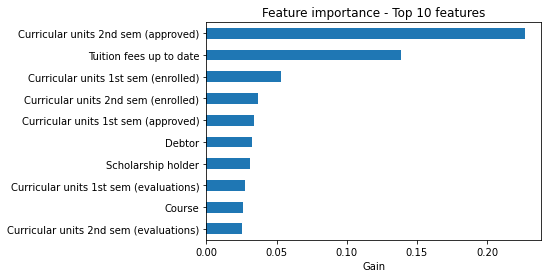

In [6]:
# global importance

imp = pd.Series(gbm.feature_importances_, index=gbm.feature_names_in_)
imp.sort_values(ascending=True, inplace=True)
imp.tail(10).plot.barh()
plt.xlabel("Gain")
plt.title("Feature importance - Top 10 features")
plt.show()

## Tree SHAP

**Important**: we pass the model and not `gbm.predict_proba` as we did with the `PermutationExplainer`. Subtle differences that may confuse at the beginning. In both cases, the Shapley values will explain the probabilities.

In [7]:
explainer = shap.TreeExplainer(gbm, X_train)

In [8]:
# corroborate that we have the right explainer

explainer.__class__

shap.explainers._tree.TreeExplainer

There are 2 methods to determine Shapley values for trees. 

We want to use the exact calculation, so we need to set up `feature_perturbation` to `'interventional'`, which is done automatically if you pass background data. 

But if you forget it, this will work as well, with a different Shapley value calculation.

In [9]:
# make sure it says interventional here, otherwise
# it is using a different way to calculate SHAP

explainer.feature_perturbation

'interventional'

In [10]:
# obtain the shap values

shap_values = explainer(X_test)

 98%|===================| 2612/2655 [00:37<00:00]        

In [11]:
# there are 1 shapley value per class

shap_values

.values =
array([[[-1.20632187e-03, -1.75390296e-02,  9.89160666e-03],
        [ 5.33385873e-04,  1.39407268e-02, -3.67031811e-02],
        [-4.60452516e-02, -4.40241791e-02, -8.82741536e-02],
        ...,
        [-2.09102277e-01, -1.50406370e-01,  2.37510078e-01],
        [-1.11659533e-01,  4.27392519e-02,  2.58976223e-02],
        [-1.19968020e-01,  1.15863254e-03,  5.93519696e-02]],

       [[-5.14634125e-03, -2.93756313e-03,  3.76804705e-03],
        [ 5.27660649e-03, -1.75973469e-02,  2.27917281e-01],
        [-2.55047008e-01,  9.06123293e-02,  8.47521751e-02],
        ...,
        [ 1.74436386e-02,  4.86854233e-02, -8.35342033e-02],
        [-5.01231282e-02,  9.56787390e-02, -2.74688216e-02],
        [-4.83414101e-02, -3.25758059e-03,  8.14273952e-02]],

       [[-5.07656747e-03, -4.00975098e-03,  5.74977242e-03],
        [ 5.67933345e-02, -3.98822631e-03,  1.93986168e-01],
        [-1.49934182e-01,  1.33875206e-01, -2.52124458e-02],
        ...,
        [ 1.11942914e-01, -9.809

### Global explanations

With beeswarm plots we can see the range of impact of each feature on the target value. It gives an idea of global importance.

#### Graduate

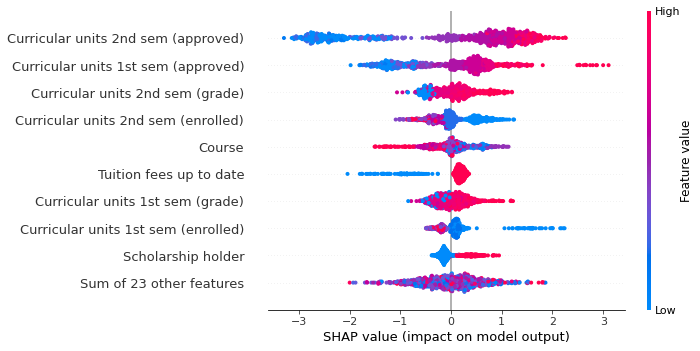

In [12]:
shap.plots.beeswarm(shap_values[:,:,1])

- The larger the SHAP value range, the more important the feature.
- The color indicates the feature magnitude

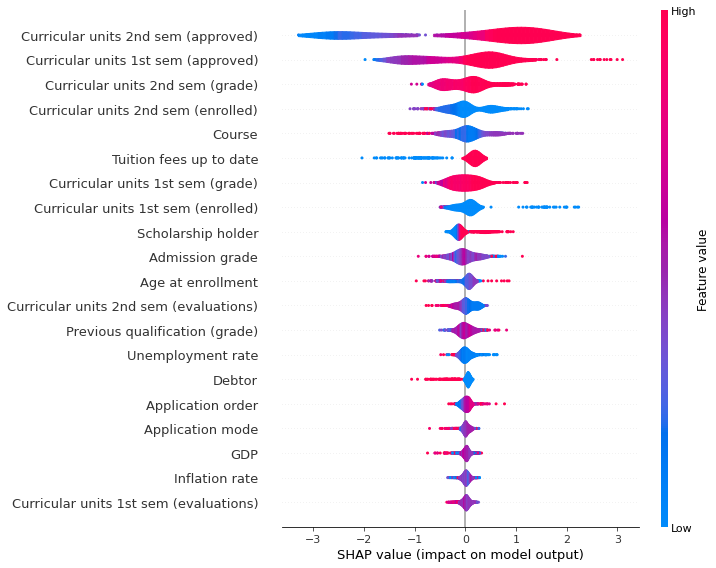

In [13]:
shap.plots.violin(shap_values[:,:,1])

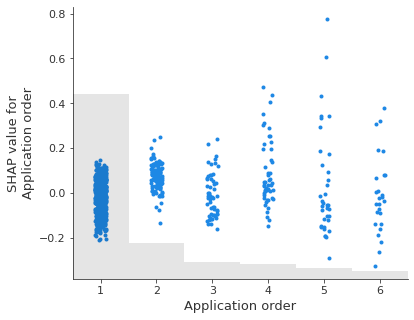

In [14]:
shap.plots.scatter(shap_values[:,"Application order",1])

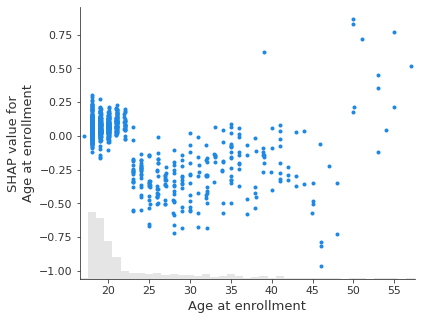

In [15]:
shap.plots.scatter(shap_values[:,"Age at enrollment",1])

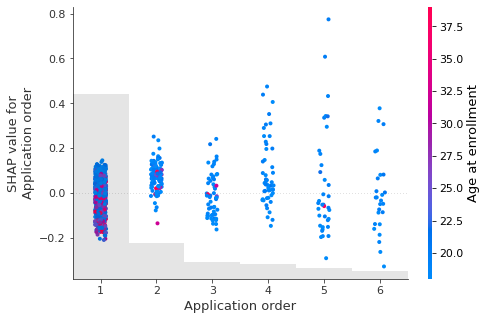

In [16]:
# we can also investigate interactions

shap.plots.scatter(shap_values[:, "Application order", 1],
                   color=shap_values[:, "Age at enrollment", 1])

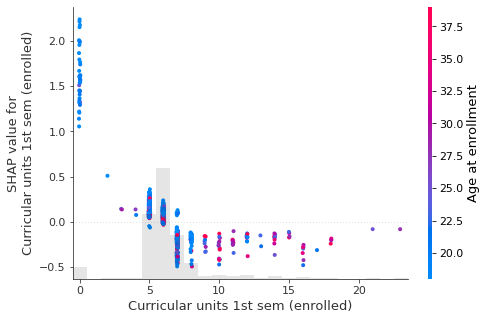

In [17]:
shap.plots.scatter(shap_values[:, "Curricular units 1st sem (enrolled)", 1],
                   color=shap_values[:, "Age at enrollment", 1])

#### Dropout

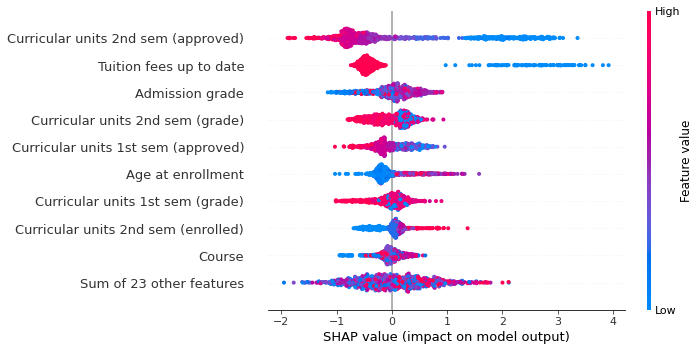

In [18]:
shap.plots.beeswarm(shap_values[:,:,2])

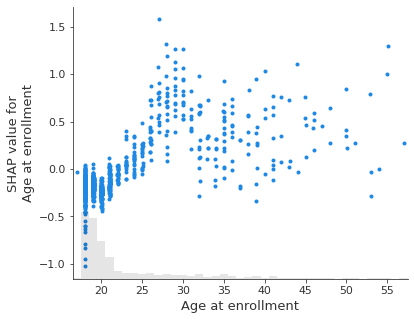

In [19]:
shap.plots.scatter(shap_values[:,"Age at enrollment",2])

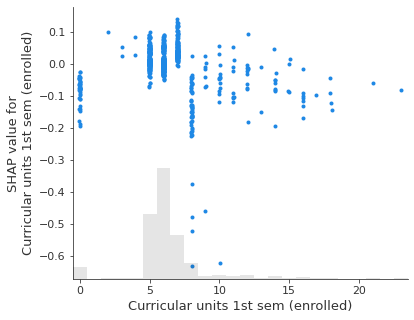

In [20]:
shap.plots.scatter(shap_values[:,"Curricular units 1st sem (enrolled)",2])

### Local explanations

We'll now make waterfall plots for specific samples.

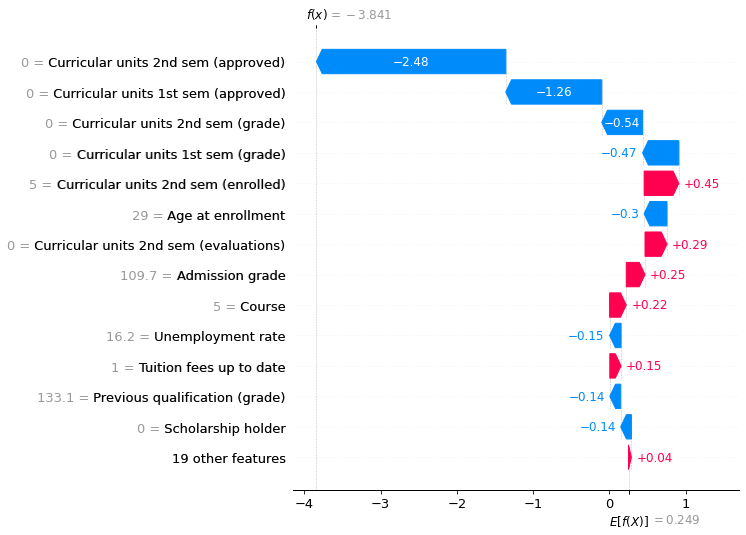

In [21]:
shap.plots.waterfall(shap_values[0, :, 1], max_display=14)

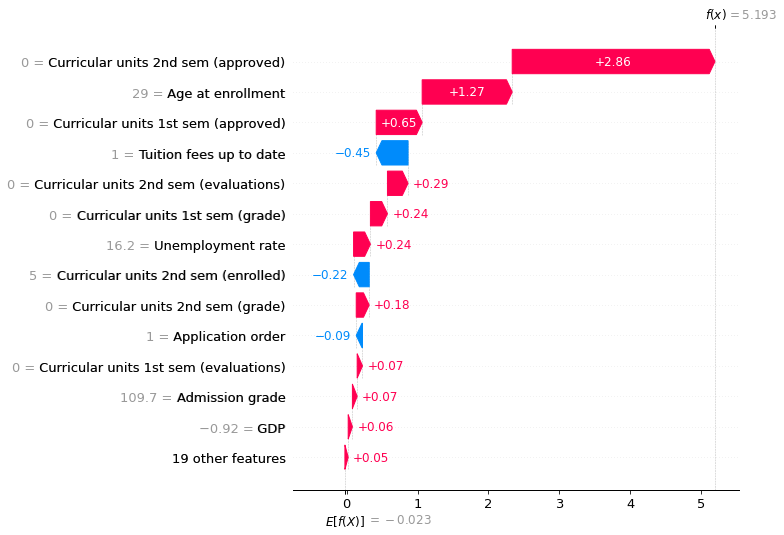

In [22]:
shap.plots.waterfall(shap_values[0, :, 2], max_display=14)

The waterfall plot starts at the expectation without features (mean of the target) and shows how each feature moves the price away (up or down) respect to the origin.

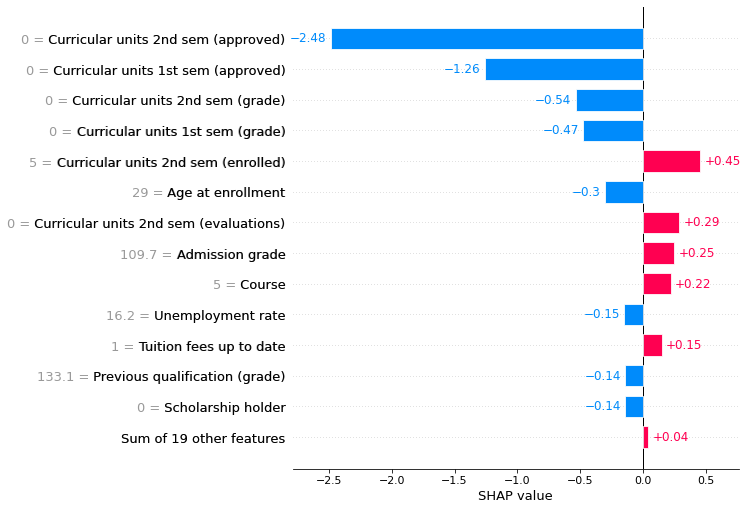

In [23]:
shap.plots.bar(shap_values[0, :, 1], max_display=14)

The bar plot shows how each feature modifies the house price, irrespective of the origin (target mean).

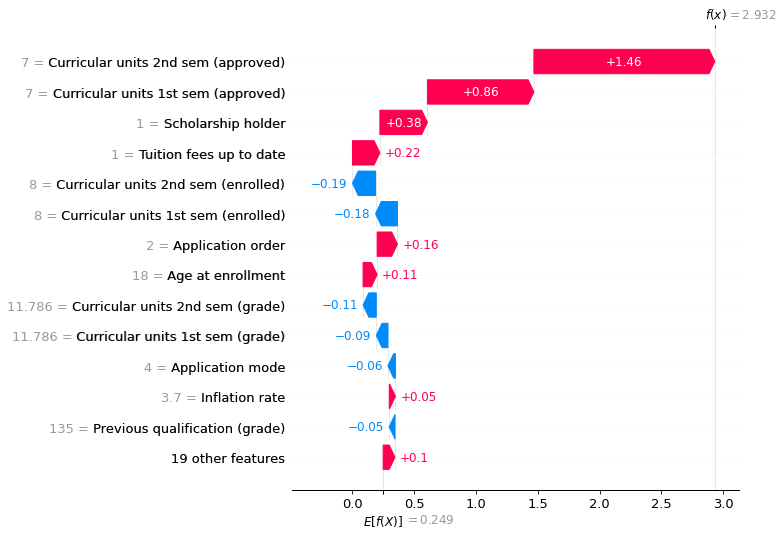

In [24]:
shap.plots.waterfall(shap_values[20, :, 1], max_display=14)

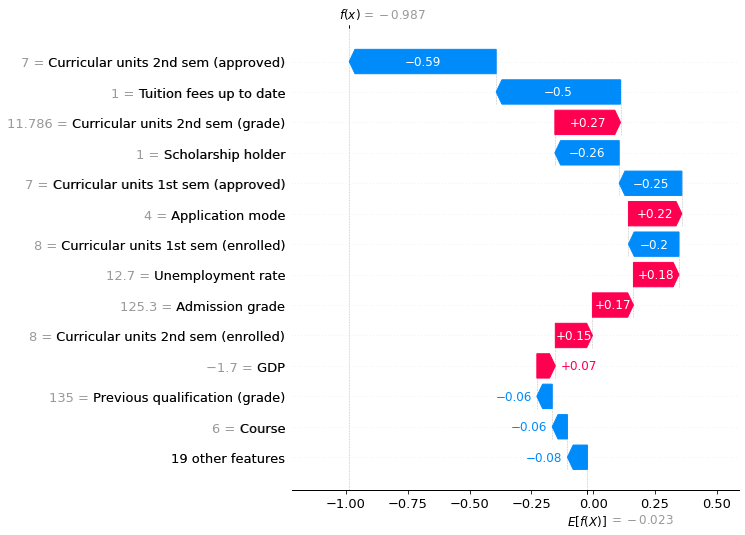

In [25]:
shap.plots.waterfall(shap_values[20, :, 2], max_display=14)

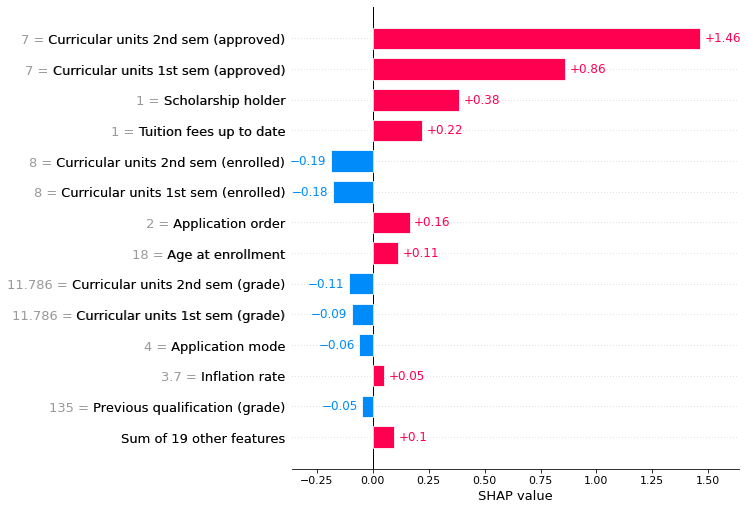

In [26]:
shap.plots.bar(shap_values[20, :, 1], max_display=14)